In [1]:
import hashlib
import os
import pickle
from hwcomponents_cacti import SRAM as CactiSRAM
from hwcomponents_library import AladdinAdder, AladdinMultiplier

from fastfusion.frontend.architecture import Memory
from fastfusion.frontend.specification import Specification
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_sims
from fastfusion.mapper.simanneal.wrappers import join_sims

import copy
import time
from fastfusion import Specification
from fastfusion.mapper.metrics import Metrics
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_sims
from fastfusion.mapper.FFM.joining.sim import SIM
from fastfusion.mapper.FFM.joining.simexplore import join_sims
import fastfusion.mapper.FFM.exploration.mapper_one_einsum as mapper_one_einsum

from fastfusion.mapper.FFM.exploration.mapping_filter_tags.ffmt import get_ffmt_tag
from fastfusion.mapper.FFM.exploration.mapping_filter_tags.onesplit import get_one_split_tag
from fastfusion.mapper.FFM.pareto import PartialMappings
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

# TODO: Make a setting for the below two in the spec
# TODO: Generate pmappings one Einsum at a time. Once we've made compatibility, check it
# against the previously-generated compatibilities and stop if there's no match.
# TODO: Once the previous is done, also add a forward check. Once the compatibilities of
# a particular Einsum are generated, we can immediately check the previous Einsums.

objective = lambda df: df['Total\0latency']# * df['Total_Energy']
LOAD_FROM_CACHE = True

def get_fused_mappings(
        spec: Specification, 
        cache_key=None,
        parameterization="",
    ) -> PartialMappings:
    os.makedirs("cache", exist_ok=True)
    if cache_key is not None:
        fname = parameterization + "-".join(str(x) for x in cache_key)
        if LOAD_FROM_CACHE and os.path.exists(f"cache/{fname}.pkl"):
            print(f"Loading from cache: {fname}")
            mappings = pickle.load(open(f"cache/{fname}.pkl", "rb"))
            return objective(mappings.data).min() if mappings is not None else None, mappings
    spec = copy.deepcopy(spec)
    
    main_memory: Memory = spec.architecture.nodes["MainMemory"]
    if parameterization == "Unfused":
        main_memory.constraints.tensors.keep = "All()"
    elif parameterization == "FlashAttention B":
        main_memory.constraints.tensors.keep = "~bypass"
        main_memory.constraints.tensors.bypass = "I | Q | K | V | QK | QK_softmax"#Q | K | V | I"# | QK | FFA"
    elif parameterization == "FlashAttention A":
        main_memory.constraints.tensors.keep = "~bypass"
        main_memory.constraints.tensors.bypass = "QK | QK_softmax"#Q | K | V | I"# | QK | FFA"
    elif parameterization == "FFM":
        main_memory.constraints.tensors.keep = "~Intermediates()" #"# | AV | Z "
        pass
    elif parameterization == "Fixed-Dataflow":
        main_memory.constraints.tensors.keep = "~Intermediates() | weight"
        spec.architecture.nodes["GlobalBuffer"].constraints.dataflow.tensor_order_options = [
            ["MainMemory.tensors() & weight", "MainMemory.tensors() & input", "MainMemory.tensors() & output", "weight - MainMemory.tensors()", "input - MainMemory.tensors()", "output - MainMemory.tensors()"],
        ]
    else:
        assert False, f"Parameterization {parameterization} not supported"
    
    spec.calculate_component_energy_area()
    if LOAD_FROM_CACHE and cache_key is not None and os.path.exists(f"pmappings_cache/{fname}.pkl"):
        print(f"Loading from cache: {fname}")
        pmappings = pickle.load(open(f"cache/pmappings_{fname}.pkl", "rb"))
    else:
        pmappings = make_pmappings(spec)
        pickle.dump(pmappings, open(f"cache/pmappings_{fname}.pkl", "wb"))
    try:
        mappings = join_pmappings(spec, pmappings)
    except:
        mappings = None

    # TODO: the final joined pmappings have lambdas somewhere, which can't be pickled.
    if cache_key is not None:
        pickle.dump(mappings, open(f"cache/{fname}.pkl", "wb"))
        
    return objective(mappings.data).min() if mappings is not None else None, mappings

parameterization2edp = {}
parameterization2mappings = {}

parameterizations = ["Unfused", "FlashAttention A", "FlashAttention B", "Fixed-Dataflow", "FFM"]
# for batch_size, n_tokens in [(64, 512), (1, 8192), (1, 16384), (1, 32768), (64, 8192), (64, 16384), (64, 32768)]:
for batch_size, n_tokens in [(64, 512), (1, 8192), (1, 32768)]:
        for n_pes in [256]:# [64, 256]:
            spec = Specification.from_yaml(
                f"architecture/tpu_like_asplos.arch.yaml",
                "workloads/mha_full.workload.yaml",
                "workloads/mha_full.renames.yaml",
                jinja_parse_data={
                    "BATCH_SIZE": batch_size,
                    "N_TOKENS": n_tokens,
                    "N_PES": n_pes,
                }
            )
            spec.mapper.ffm.metrics = Metrics.LATENCY
            cache_key = (batch_size, n_tokens, n_pes)
            spec.architecture.nodes["LocalBuffer"].spatial["Z"].fanout = n_pes
            for parameterization in parameterizations:
                x, mappings = get_fused_mappings(
                    spec,
                    cache_key=cache_key,
                    parameterization=parameterization,
                )
                parameterization2edp.setdefault((batch_size, n_tokens, n_pes), {})[parameterization] = x
                parameterization2mappings.setdefault((batch_size, n_tokens, n_pes), {})[parameterization] = mappings

WARNING Loading configuration file from /home/gilbertm/work/infrastructure/venv/fastfusion/config.yaml
WARNING Loading configuration file from /home/gilbertm/work/infrastructure/venv/fastfusion/config.yaml


Loading from cache: Unfused64-512-256
Loading from cache: FlashAttention A64-512-256
Loading from cache: FlashAttention B64-512-256
Loading from cache: Fixed-Dataflow64-512-256
Loading from cache: FFM64-512-256
Loading from cache: Unfused1-8192-256


WARNING Loading configuration file from /home/gilbertm/work/infrastructure/venv/fastfusion/config.yaml


Loading from cache: FlashAttention A1-8192-256
Loading from cache: FlashAttention B1-8192-256
Loading from cache: Fixed-Dataflow1-8192-256
Loading from cache: FFM1-8192-256
Loading from cache: Unfused1-32768-256
Loading from cache: FlashAttention A1-32768-256
Loading from cache: FlashAttention B1-32768-256
Loading from cache: Fixed-Dataflow1-32768-256
Loading from cache: FFM1-32768-256


Elementwise-Only: {'Batch=64\nSeq. length=512': np.float64(0.27285390803099696), 'Batch=1\nSeq. length=8k': np.float64(0.04927433922747447), 'Batch=1\nSeq. length=32k': np.float64(0.02675507038893531)}
FlashAttention: {'Batch=64\nSeq. length=512': np.float64(0.45709841694467), 'Batch=1\nSeq. length=8k': np.float64(0.47993180829615223), 'Batch=1\nSeq. length=32k': np.float64(0.6504716129657209)}
Fast & Fusiest: {'Batch=64\nSeq. length=512': np.float64(1.0), 'Batch=1\nSeq. length=8k': np.float64(1.0), 'Batch=1\nSeq. length=32k': np.float64(1.0)}


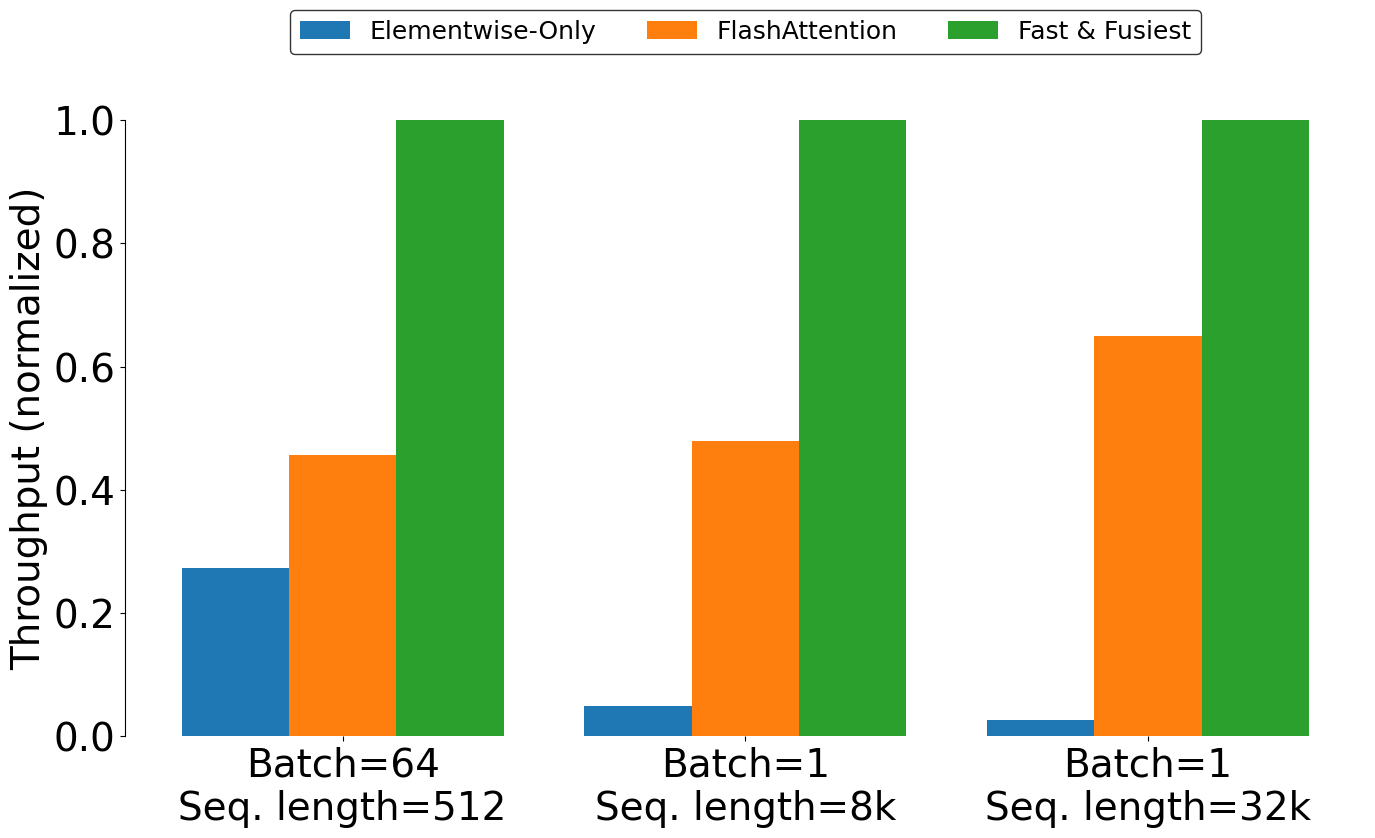

In [5]:
results = parameterization2edp

import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams.update({'font.size': 28})

def plot_default_formatting(ax, grid_axis='both'):
    ax.tick_params(axis='both', which='major')#, labelsize=20)
    ax.tick_params(axis='both', which='minor')#, labelsize=20)

    # Set legend ncols to 5
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    legend = ax.legend(fontsize=18, ncols=5, loc="upper center", bbox_to_anchor=(0.5, 1.2))
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('black')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # ax.minorticks_on()
    # ax.grid(axis=grid_axis, which='major', linestyle='-', linewidth='0.3', color='gray')
    # ax.grid(axis=grid_axis, which='minor', linestyle='--', linewidth='0.1', color='lightgray')

colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#ff0000",
]

def make_bar_chart(
    data,
    title,
    xlabel,
    ylabel,
    y_scale,
    output_file=None,
    normalize: bool = False,
    ylim=(None, None),
    xlim=(None, None),
):
    """
    Create a bar chart from the given data and save it as a PDF.
    """
    plt.figure(figsize=(16, 8))
    
    if isinstance(data, dict) and isinstance(next(iter(data.values())), dict):
        bar_width = 0.8 / len(data)
        keys = list(next(iter(data.values())).keys())
        x = range(len(keys))
        first = next(iter(data.values()))
            
        for i, (label, values) in enumerate(data.items()):
            bar_positions = [pos + i * bar_width for pos in x]
            to_plot = values
            if normalize:
                to_plot = {k: v / first[k] for k, v in values.items()}
            bars = plt.bar(bar_positions, to_plot.values(), width=bar_width, label=label, color=colors[i])
        plt.xticks([pos + (len(data) - 1) * bar_width / 2 for pos in x], keys)
        # plt.legend(loc='upper right', fontsize=10)
        plt.legend(fontsize=10, ncol=len(data), loc='upper center', bbox_to_anchor=(0.5, 0.75))
    else:
        keys = list(data.keys())
        bars = plt.bar(keys, data.values())
        

    # Set logarithmic scale for Y-axis if specified
    if y_scale == 'log':
        plt.yscale('log')

    # Add labels and title
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(ylim)
    plt.xlim(xlim)

    # Rotate X-axis labels vertically
    # plt.xticks(rotation=90)
    
    plot_default_formatting(plt.gca(), grid_axis='y')
    
    if output_file is not None:
        with open(output_file, 'wb') as f:
            plt.savefig(f, format='pdf', bbox_inches='tight')

    # Show the plot
    plt.show()

entries = {}

name_changes = {
    "Unfused": "Elementwise-Only",
    "FlashAttention A": "FlashAttention",
    "Fixed-Dataflow": "FLAT",
    "FlashAttention B": "FlashAttention B",
    "FFM": "Fast & Fusiest",
    # (64, 512, 64): "Big Batch\n64 Cores",
    (64, 512, 256): "Batch=64\nSeq. length=512",#\n256 Cores",
    # (1, 16384, 64): "Big Seq\n64 Cores",
    (1, 8192, 256): "Batch=1\nSeq. length=8k",#\n256 Cores",
    # (1, 32768, 256): "Bigger Seq\n256 Cores",
    (1, 32768, 256): "Batch=1\nSeq. length=32k",#\n256 Cores",
}

for k, v in results.items():
    if k not in name_changes:
        continue
    k = name_changes.get(k, k)
    entries[k] = {name_changes.get(k2, k2): 1/v[k2] if v[k2] else 0 for k2 in v}
    max_val = max(entries[k].values())
    for k2, v2 in entries[k].items():
        entries[k][k2] = v2 / max_val if max_val else 0

entries={k: v for k, v in sorted(entries.items(), key=lambda x: list(name_changes.values()).index(x[0]))}

# Transpose everything
entries2 = {}
for k, v in entries.items():
    for k2, v2 in v.items():
        entries2.setdefault(k2, {})[k] = v2
entries = entries2

del entries2['FlashAttention B']
del entries2['FLAT']

# Print as a table
for name, e in entries2.items():
    print(f"{name}: {e}")
    
make_bar_chart(entries, title=None, xlabel=None, ylabel="Throughput (normalized)", y_scale='linear', output_file="mapsapce_compare.pdf", normalize=False, ylim=(0, 1), xlim=(None, None))